**Objective**:
- create a model that could predict sunspots based on timeseries historical data
- desired MAE is < 0.15 using the normalized dataset

**Further reading**: https://medium.com/analytics-vidhya/time-series-forecasting-using-tensorflow-rkt109-ea858d8e49c6

# Data Preparation

In [10]:
# set up useful libraries
import urllib
import csv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# retrieve online data and save it into a csv file
data_url = 'https://github.com/dicodingacademy/assets/raw/main/Simulation/machine_learning/sunspots.csv'
urllib.request.urlretrieve(data_url, 'sunspots.csv')

# load the data into a list (dataset)
sunspots = []
time_step = []
with open('sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

# verifying
print("retrieved sunspots data collection has a length of: {}".format(len(sunspots)))
print("retrieved time_step data collection has a length of: {}".format(len(time_step)))

retrieved sunspots data collection has a length of: 3265
retrieved time_step data collection has a length of: 3265


In [3]:
# prepare the "time" and "series" dataset
time = np.array(time_step)
series = np.array(sunspots)

# conduct min-max normalization to the series
min = np.min(series)
max = np.max(series)
series -= min
series /= max

# split the dataset for training & validation purpose
n_split = 3000
time_train = time[:n_split]
x_train = series[:n_split]
time_valid = time[n_split:]
x_valid = series[n_split:]

In [4]:
# function to create a windowed dataset
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[1:]))
  return ds.batch(batch_size).prefetch(1)

# Modeling

In [5]:
# create a windowed dataset to train the model
window_size = 30
batch_size = 32
shuffle_buffer_size = 1000
train_set_windowed = windowed_dataset(x_train, window_size=window_size, batch_size=batch_size,shuffle_buffer=shuffle_buffer_size)

In [6]:
# define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64, kernel_size=3,
                           strides=1,
                           activation="relu",
                           padding='causal',
                           input_shape=[window_size, 1]),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(30, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
    ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 64)            256       
                                                                 
 lstm (LSTM)                 (None, 30, 64)            33024     
                                                                 
 lstm_1 (LSTM)               (None, 30, 64)            33024     
                                                                 
 lstm_2 (LSTM)               (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 30)                3870      
                                                                 
 dense_1 (Dense)             (None, 10)                310       
                                                                 
 dropout (Dropout)           (None, 10)                0

In [7]:
# function to halt a model training process
class MyCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('mae') < 0.15:
      print("\nReached desired metric(s) so cancelling training!")
      self.model.stop_training = True

In [8]:
# build/compile the model
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch/20))
optimizer = tf.keras.optimizers.SGD(momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [9]:
# train the model
history = model.fit(train_set_windowed, epochs=100, callbacks=[MyCallback(), lr_scheduler], verbose=2)

Epoch 1/100
93/93 - 37s - loss: 0.0373 - mae: 0.2108 - lr: 1.0000e-08 - 37s/epoch - 395ms/step
Epoch 2/100
93/93 - 8s - loss: 0.0373 - mae: 0.2109 - lr: 1.1220e-08 - 8s/epoch - 86ms/step
Epoch 3/100
93/93 - 9s - loss: 0.0373 - mae: 0.2109 - lr: 1.2589e-08 - 9s/epoch - 94ms/step
Epoch 4/100
93/93 - 9s - loss: 0.0374 - mae: 0.2110 - lr: 1.4125e-08 - 9s/epoch - 101ms/step
Epoch 5/100
93/93 - 9s - loss: 0.0374 - mae: 0.2110 - lr: 1.5849e-08 - 9s/epoch - 100ms/step
Epoch 6/100
93/93 - 9s - loss: 0.0373 - mae: 0.2108 - lr: 1.7783e-08 - 9s/epoch - 98ms/step
Epoch 7/100
93/93 - 8s - loss: 0.0374 - mae: 0.2109 - lr: 1.9953e-08 - 8s/epoch - 86ms/step
Epoch 8/100
93/93 - 8s - loss: 0.0373 - mae: 0.2108 - lr: 2.2387e-08 - 8s/epoch - 91ms/step
Epoch 9/100
93/93 - 11s - loss: 0.0373 - mae: 0.2108 - lr: 2.5119e-08 - 11s/epoch - 118ms/step
Epoch 10/100
93/93 - 9s - loss: 0.0372 - mae: 0.2106 - lr: 2.8184e-08 - 9s/epoch - 101ms/step
Epoch 11/100
93/93 - 8s - loss: 0.0372 - mae: 0.2106 - lr: 3.1623e-08 

# Evaluation

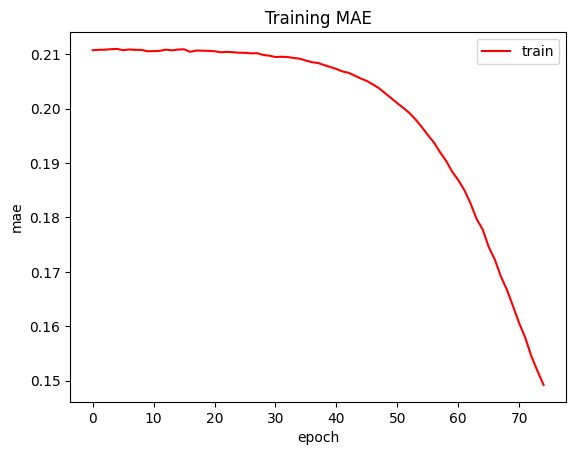

In [38]:
plt.plot(history.history['mae'], 'red')
plt.title('Training MAE')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()